📥 Loading data...
✅ Train Labels: {np.int64(1): 100, np.int64(0): 100}
✅ Test Labels : {np.int64(1): 838, np.int64(0): 82}

🧪 Running Fuzzy K-NN with k=9, m=2.0...

📊 Evaluation Metrics:
Accuracy              : 49.35%
Precision (TP = 1)    : 0.9471
Precision (TN = 0)    : 0.1190
Recall    (TP = 1)    : 0.4702
Recall    (TN = 0)    : 0.7317
F1-Score  (TP = 1)    : 0.6284
F1-Score  (TN = 0)    : 0.2048
Specificity (TN)      : 0.7317
False Positive Rate   : 0.2683
False Negative Rate   : 0.5298
Support (TP = 1)      : 838
Support (TN = 0)      : 82

📋 Classification Report:
              precision    recall  f1-score   support

          TN       0.12      0.73      0.20        82
          TP       0.95      0.47      0.63       838

    accuracy                           0.49       920
   macro avg       0.53      0.60      0.42       920
weighted avg       0.87      0.49      0.59       920


📌 Reordered Confusion Matrix:
[[394 444]
 [ 22  60]]

📋 Confusion Matrix Table (Reordered):
  

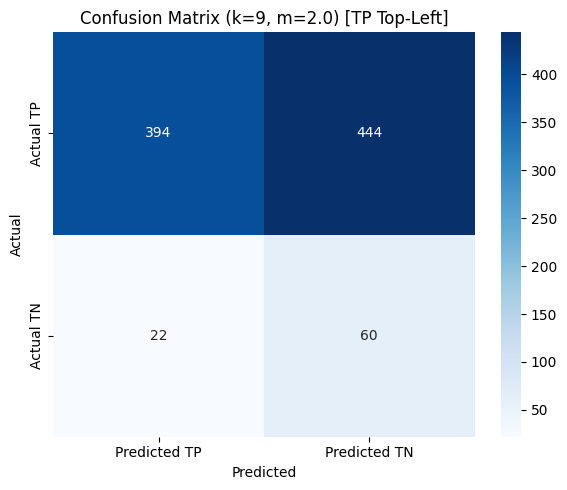

In [3]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# === CONFIG ===
base_path = r'C:\Users\BMEi\Documents\GitHub\WORK\Windows\CODE_BME\PROJECT_CYBER_SECURITY'

# Paths
matrix_path = os.path.join(base_path, r'RESULT\09.fix_edit_distance_matrix\EDIT_DISTANCE_MATRIX_FINAL_FIXED.csv')
malware_test_path = os.path.join(base_path, r'RESULT\01.TRAIN_TEST_SET\malware_test.json')
benign_test_path  = os.path.join(base_path, r'RESULT\01.TRAIN_TEST_SET\benign_test.json')
train_path = os.path.join(base_path, r'RESULT\05.DATA_VALIDATION\fold_3\MALWARE_100_BENIGN_100\validation_train.json')

# === LOAD DATA ===
print("📥 Loading data...")
distance_matrix = pd.read_csv(matrix_path, header=None).values

def read_multiline_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

malware_test = read_multiline_json(malware_test_path)
benign_test  = read_multiline_json(benign_test_path)
test_labels = np.array([1] * len(malware_test) + [0] * len(benign_test))

with open(train_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

def parse_label(label):
    label = str(label).lower()
    return 1 if label == "malware" or label == "1" else 0

train_labels = np.array([parse_label(d.get("label", "")) for d in train_data])

print("✅ Train Labels:", dict(Counter(train_labels)))
print("✅ Test Labels :", dict(Counter(test_labels)))

# === FUZZY K-NN ===
def fuzzy_knn_classify(distances, train_labels, k=5, m=2.0):
    idx_sorted = np.argsort(distances)[:k]
    top_d = distances[idx_sorted]
    top_l = train_labels[idx_sorted]
    eps = 1e-8
    similarity = 1.0 / (top_d + eps)
    weights = similarity ** (2 / (m - 1))
    class_votes = {}
    for label in np.unique(train_labels):
        vote = np.sum(weights[top_l == label])
        class_votes[label] = vote
    return max(class_votes, key=class_votes.get)

# === FIXED PARAMETERS ===
k = 9
m = 2.0

print(f"\n🧪 Running Fuzzy K-NN with k={k}, m={m}...")

# Predict
predictions = []
for col in range(distance_matrix.shape[1]):
    distances = distance_matrix[:, col]
    pred = fuzzy_knn_classify(distances, train_labels, k=k, m=m)
    predictions.append(pred)

# === METRICS ===
acc = accuracy_score(test_labels, predictions)

prec_tp = precision_score(test_labels, predictions, pos_label=1, zero_division=0)
prec_tn = precision_score(test_labels, predictions, pos_label=0, zero_division=0)
rec_tp  = recall_score(test_labels, predictions, pos_label=1, zero_division=0)
rec_tn  = recall_score(test_labels, predictions, pos_label=0, zero_division=0)
f1_tp   = f1_score(test_labels, predictions, pos_label=1, zero_division=0)
f1_tn   = f1_score(test_labels, predictions, pos_label=0, zero_division=0)

# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
TN, FP, FN, TP = cm.ravel()

# Reordered matrix: [[TP, FN], [FP, TN]]
cm_reordered = np.array([[TP, FN],
                         [FP, TN]])

# Extra metrics
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
support_tn = TN + FP
support_tp = TP + FN

# === PRINT METRICS ===
print("\n📊 Evaluation Metrics:")
print(f"Accuracy              : {acc * 100:.2f}%")
print(f"Precision (TP = 1)    : {prec_tp:.4f}")
print(f"Precision (TN = 0)    : {prec_tn:.4f}")
print(f"Recall    (TP = 1)    : {rec_tp:.4f}")
print(f"Recall    (TN = 0)    : {rec_tn:.4f}")
print(f"F1-Score  (TP = 1)    : {f1_tp:.4f}")
print(f"F1-Score  (TN = 0)    : {f1_tn:.4f}")
print(f"Specificity (TN)      : {specificity:.4f}")
print(f"False Positive Rate   : {fpr:.4f}")
print(f"False Negative Rate   : {fnr:.4f}")
print(f"Support (TP = 1)      : {support_tp}")
print(f"Support (TN = 0)      : {support_tn}")

# === CLASSIFICATION REPORT ===
print("\n📋 Classification Report:")
print(classification_report(test_labels, predictions, target_names=["TN", "TP"], zero_division=0))

# === REORDERED CONFUSION MATRIX ===
cm_df = pd.DataFrame(cm_reordered,
                     index=['Actual TP', 'Actual TN'],
                     columns=['Predicted TP', 'Predicted TN'])

print("\n📌 Reordered Confusion Matrix:")
print(cm_reordered)
print("\n📋 Confusion Matrix Table (Reordered):")
print(cm_df)

# === PLOT HEATMAP ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (k={k}, m={m}) [TP Top-Left]')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()